## ECE 239 Final Project

In this project we explore various deep learning algorithms on the EEG dataset. 


In [3]:
# Imports and setup

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM
from keras.layers import GRU
import matplotlib.pyplot as plt

from utils.load_data import *
from utils.utilities import *
from models.cnn import CNN
from models.rnn import RNN
from models.autoencoder import Autoencoder


%load_ext autoreload
%autoreload 2

In [4]:
# Loads data from the EEG dataset and removes all EOG data

person_train_val, X_train_val, y_train_val, person_test, X_test, y_test = load_EEG_data()

print ('Training/Valid data shape: {}'.format(X_train_val.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_val.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_val.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


### Split into train and validation datasets

In [5]:
X_train, y_train, X_val, y_val = split_train_val(X_train_val, y_train_val, percent_validation=0.1)

print ('Training data shape: {}'.format(X_train.shape))
print ('Training target shape: {}'.format(y_train.shape))
print ('Validation data shape: {}'.format(X_val.shape))
print ('Validation target shape: {}'.format(y_val.shape))

Training data shape: (1904, 22, 1000)
Training target shape: (1904,)
Validation data shape: (211, 22, 1000)
Validation target shape: (211,)


## One hot encoding for all labels

In [6]:
print (y_val[33])
print (y_val.shape)
print (y_test.shape)

y_train_labels = one_hot_encode(y_train)
y_val_labels = one_hot_encode(y_val)
y_test_labels = one_hot_encode(y_test)

print (y_val_labels[33])
print (y_val_labels.shape)
print (y_test_labels.shape)


771
(211,)
(443,)
[0. 0. 1. 0.]
(211, 4)
(443, 4)


## Viewing the data for different classes

as you can see, there is not much of a difference

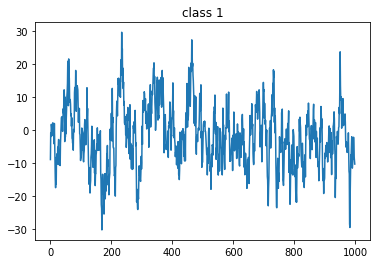

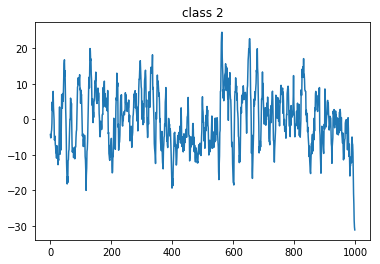

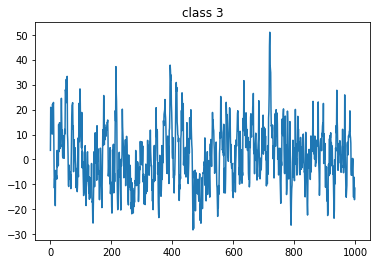

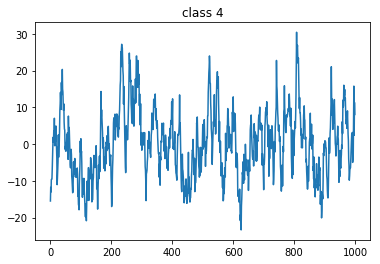

In [75]:
class1 = np.argmax( y_train == 769)
class2 = np.argmax( y_train == 770)
class3 = np.argmax( y_train == 771)
class4 = np.argmax( y_train == 772)
EEG0_class1 = X_train[class1,0,:]
EEG0_class2 = X_train[class2,0,:]
EEG0_class3 = X_train[class3,0,:]
EEG0_class4 = X_train[class4,0,:]

plt.plot(range(1000), EEG0_class1)
plt.title("class 1")
plt.show()

plt.plot(range(1000), EEG0_class2)
plt.title("class 2")
plt.show()

plt.plot(range(1000), EEG0_class3)
plt.title("class 3")
plt.show()

plt.plot(range(1000), EEG0_class4)
plt.title("class 4")
plt.show()

## Classifying data using a CNN

In [51]:
cnn = CNN(X_train, y_train_labels, X_val, y_val_labels, X_test, y_test_labels, samples=1000)
cnn.train(stride=2, optimizer='adam', epochs=7)
test_loss, test_accuracy = cnn.evaluate()

#cnn.show_model()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Train on 1904 samples, validate on 211 samples
Epoch 1/7
1904/1904 [==============================] - 3s 1ms/sample - loss: 1.4207 - acc: 0.2447 - val_loss: 1.4020 - val_acc: 0.2512
Epoch 2/7
1904/1904 [==============================] - 0s 203us/sample - loss: 1.3906 - acc: 0.2631 - val_loss: 1.3772 - val_acc: 0.2749
Epoch 3/7
1904/1904 [==============================] - 0s 201us/sample - loss: 1.3861 - acc: 0.2563 - val_loss: 1.3868 - val_acc: 0.2749
Epoch 4/7
1904/1904 [==============================] - 0s 207us/sample - loss: 1.3809 - acc: 0.2805 - val_loss: 1.4201 - val_acc: 0.2133
Epoch 5/7
1904/1904 [==============================] - 0s 225us/sample - loss: 1.3846 - acc: 0.2705 - val_loss: 1.3978 - val_acc: 0.3175
Epoch 6/7
1904/1904 [==============================] - 0s 217us/sample - loss: 1.3725 - acc: 0.2831 - val_loss: 1.4228 - val_acc: 0.2322
Epoch 7/7
443/443 [==============================] - 0s 80us/sample - loss: 1.4390 - acc: 0.2122
Test loss: 1.439036859077471
Test ac

## Classifying data using an LSTM Architecture

Train on 1904 samples, validate on 211 samples
Epoch 1/10
1904/1904 [==============================] - 17s 9ms/step - loss: 1.4175 - acc: 0.2826 - val_loss: 1.3561 - val_acc: 0.2844
Epoch 2/10
1904/1904 [==============================] - 5s 3ms/step - loss: 1.3547 - acc: 0.3225 - val_loss: 1.3107 - val_acc: 0.3649
Epoch 3/10
1904/1904 [==============================] - 5s 3ms/step - loss: 1.3055 - acc: 0.3850 - val_loss: 1.3062 - val_acc: 0.3981
Epoch 4/10
1904/1904 [==============================] - 5s 3ms/step - loss: 1.2656 - acc: 0.4207 - val_loss: 1.2744 - val_acc: 0.4597
Epoch 5/10
1904/1904 [==============================] - 5s 3ms/step - loss: 1.1979 - acc: 0.4648 - val_loss: 1.3121 - val_acc: 0.4076
Epoch 6/10
1904/1904 [==============================] - 5s 3ms/step - loss: 1.1261 - acc: 0.5042 - val_loss: 1.3313 - val_acc: 0.3839
Epoch 7/10
1904/1904 [==============================] - 5s 3ms/step - loss: 1.0453 - acc: 0.5657 - val_loss: 1.4043 - val_acc: 0.4123
Epoch 8/10
190

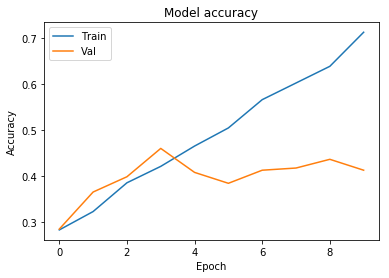

In [80]:
rnn = RNN(X_train, y_train_labels, X_val, y_val_labels, 
          X_test, y_test_labels,
          start=0, end=400, downsample=10)
rnn.train(RNN_architecture=LSTM, activation="softmax", \
              optimizer='adam', epochs=10, batch_size=64, dropout=0.6, units=400)
test_loss, test_accuracy = rnn.evaluate()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

rnn.show_model()
rnn.plot()

## Check Results

In [81]:
# TRAINING
print("TRAINING")
N = 400
sampleX = X_train[0:N,:,:]
sampleY = y_train_labels[0:N]
predictedY = rnn.predict(sampleX)
predictedLabels = np.argmax(predictedY, axis=1)
sampleLabels = np.argmax(sampleY, axis=1)

print("Predicted labels:")
print(predictedLabels)
print("Actual labels:")
print(sampleLabels)

num_equal = np.sum(1.0*np.equal(sampleLabels, predictedLabels))
print("Number of labels that are equal:")
print(num_equal)
print("Accuracy: ")
print(num_equal/N)

# VALIDATION
print("VALIDATION")
N = 400
sampleX = X_val[0:N,:,:]
sampleY = y_val_labels[0:N]
predictedY = rnn.predict(sampleX)
predictedLabels = np.argmax(predictedY, axis=1)
sampleLabels = np.argmax(sampleY, axis=1)

print("Predicted labels:")
print(predictedLabels)
print("Actual labels:")
print(sampleLabels)

num_equal = np.sum(1.0*np.equal(sampleLabels, predictedLabels))
print("Number of labels that are equal:")
print(num_equal)
print("Accuracy: ")
print(num_equal/N)



TRAINING


ValueError: Error when checking input: expected sequential_59_input to have shape (22, 40) but got array with shape (22, 1000)

## Classifying Data using a GRU Architecture

In [8]:
rnn = RNN(X_train, y_train_labels, X_val, y_val_labels, X_test, y_test_labels)
rnn.train(RNN_architecture=GRU, activation="sigmoid", \
              optimizer='adam', epochs=5, batch_size=64, dropout=0.1)
test_loss, test_accuracy = rnn.evaluate()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Train on 1904 samples, validate on 211 samples
Epoch 1/5
1904/1904 [==============================] - 4s 2ms/step - loss: 1.4226 - acc: 0.2973 - val_loss: 1.3850 - val_acc: 0.2938
Epoch 2/5
1904/1904 [==============================] - 3s 1ms/step - loss: 1.1230 - acc: 0.5572 - val_loss: 1.4535 - val_acc: 0.2796
Epoch 3/5
1904/1904 [==============================] - 3s 2ms/step - loss: 0.8849 - acc: 0.6665 - val_loss: 1.4832 - val_acc: 0.3507
Epoch 4/5
1904/1904 [==============================] - 3s 1ms/step - loss: 0.6635 - acc: 0.8036 - val_loss: 1.5578 - val_acc: 0.3839
Epoch 5/5
1904/1904 [==============================] - 3s 1ms/step - loss: 0.4743 - acc: 0.8813 - val_loss: 1.5822 - val_acc: 0.3649
Test loss: 1.6185275849047418
Test accuracy: 0.336343114384141


In [9]:
person1_X_train, person1_y_train = extract_person_data(X_train_val, y_train_val, person_train_val, person=1)
person2_X_test, person2_y_test = extract_person_data(X_train_val, y_train_val, person_train_val, person=2)

In [10]:
rnn = RNN(person1_X_train, one_hot_encode(person1_y_train), None, None, person2_X_test, one_hot_encode(person2_y_test))
rnn.train(RNN_architecture=LSTM, activation="sigmoid", \
              optimizer='adam', epochs=5, batch_size=10, dropout=0.3)
test_loss, test_accuracy = rnn.evaluate()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Epoch 1/5
236/236 [==============================] - 3s 11ms/step - loss: 1.4474 - acc: 0.2373
Epoch 2/5
236/236 [==============================] - 1s 6ms/step - loss: 0.9805 - acc: 0.8008
Epoch 3/5
236/236 [==============================] - 1s 5ms/step - loss: 0.7643 - acc: 0.9195
Epoch 4/5
236/236 [==============================] - 1s 5ms/step - loss: 0.5826 - acc: 0.9661
Epoch 5/5
236/236 [==============================] - 1s 6ms/step - loss: 0.4142 - acc: 0.9958
Test loss: 1.4540871119095107
Test accuracy: 0.2923728816084943


## Autoencoder

In [30]:
normed_X_train = X_train/np.max(X_train)
normed_X_val = X_val/np.max(X_val)
normed_X_test = X_test/np.max(X_test)
autoencoder = Autoencoder(X_train, X_val, X_test)
autoencoder.train(epochs=20)
new_data = autoencoder.predict(X_train)



Train on 1904 samples, validate on 211 samples
Epoch 1/2
1904/1904 [==============================] - 97s 51ms/sample - loss: 106.7663 - acc: 0.0064 - val_loss: 113.1949 - val_acc: 0.0116
Epoch 2/2
1904/1904 [==============================] - 82s 43ms/sample - loss: 104.9229 - acc: 0.0087 - val_loss: 114.5821 - val_acc: 0.0062


In [31]:
abs_err = np.abs(normed_X_train - new_data)
print("Absolute Error in encoded data is roughly: " + str(np.mean(abs_err)))
print(normed_X_train[0,0,0:50])
print(new_data[0,0,0:50])


Absolute Error in encoded data is roughly: 4.569662457663877
[-0.1827957  -0.16959922 -0.16617791 -0.20234604 -0.13685239 -0.05376344
 -0.05767351 -0.03812317 -0.05229717 -0.07233627 -0.04545455 -0.08895406
 -0.06793744 -0.00439883  0.00635386  0.0083089  -0.01270772  0.08357771
  0.10606061  0.05376344 -0.00733138  0.08113392  0.02394917 -0.01759531
  0.00879765  0.04496579  0.00879765  0.07233627  0.04252199  0.06891496
  0.0801564   0.09286413  0.04692082  0.04545455  0.06158358  0.07917889
  0.08064516  0.12561095  0.12365591  0.09677419  0.08895406  0.03665689
  0.0083089  -0.0342131  -0.00928641  0.06744868  0.03470186  0.05522972
  0.09335288  0.05865103]
[-1.2293876e+00 -3.8149724e+00  1.7111117e+00  4.0169940e+00
  4.4173360e+00  4.0727730e+00  2.9728265e+00  1.9601620e+00
  3.7387919e+00 -1.2389137e+00  7.4976617e-01  5.8707900e+00
  4.1364341e+00  7.3272924e+00  9.0178833e+00  5.7771997e+00
  4.7932949e+00  7.1590228e+00  6.2723708e+00  6.3692579e+00
  5.7228751e+00  3.23384

## Plot of original data, and autoencoded data

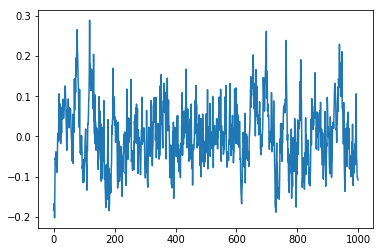

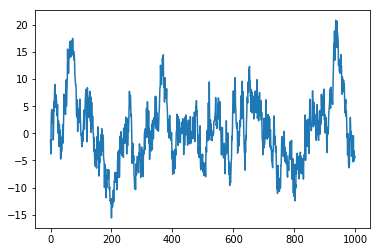

In [32]:
original = normed_X_train[0,0,:]
autoencoded = new_data[0,0,:]

plt.plot(range(len(original)), original)
plt.show()

plt.plot(range(len(autoencoded)), autoencoded)
plt.show()

## Training with autoencoder data

Train on 1904 samples, validate on 211 samples
Epoch 1/5
1904/1904 [==============================] - 12s 6ms/step - loss: 1.5768 - acc: 0.2736 - val_loss: 1.4648 - val_acc: 0.2938
Epoch 2/5
1904/1904 [==============================] - 10s 5ms/step - loss: 1.3436 - acc: 0.3645 - val_loss: 1.4586 - val_acc: 0.2654
Epoch 3/5
1904/1904 [==============================] - 10s 5ms/step - loss: 1.2623 - acc: 0.4154 - val_loss: 1.4639 - val_acc: 0.2986
Epoch 4/5
1904/1904 [==============================] - 10s 5ms/step - loss: 1.2246 - acc: 0.4354 - val_loss: 1.4482 - val_acc: 0.2938
Epoch 5/5
1904/1904 [==============================] - 10s 5ms/step - loss: 1.1715 - acc: 0.4811 - val_loss: 1.4451 - val_acc: 0.3128
Test loss: 1.4657310233966492
Test accuracy: 0.2889390520196467


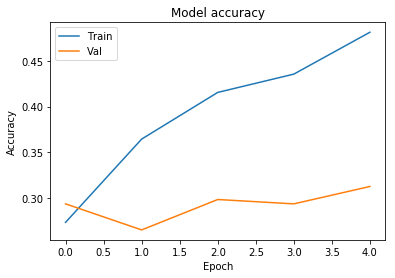

In [34]:
X_train_total = np.concatenate((X_train, new_data), axis=0)
y_train_total = np.concatenate((y_train_labels, y_train_labels), axis=0)

rnn = RNN(new_data, y_train_labels, X_val, y_val_labels, X_test, y_test_labels)
rnn.train(RNN_architecture=LSTM, activation="softmax", \
              optimizer='adam', epochs=5, batch_size=64, dropout=0.5, units=500)
test_loss, test_accuracy = rnn.evaluate()
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)


rnn.plot()